# Intertidal greenness mapping

Plan:
- Use approaches outlined in Intertidal_WIT.ipynb workflow to offer insights to intertidal areas without pre-requisite mapped habitat polygons
- Test various aquatic vegetation indices for suitability (improvements upon NDVI?)

In [1]:
## Import modules
import sys
sys.path.append("../Scripts")

import datacube
import xarray as xr

from dea_datahandling import load_ard
from dea_dask import create_local_dask_cluster
from CP_dea_plotting import display_map, rgb
from dea_coastaltools import tidal_stats, tidal_tag
from CP_dea_bandindices import calculate_indices

/env/lib/python3.6/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
## Connect to the datacube
dc = datacube.Datacube(app="Analyse_multiple_polygons")
create_local_dask_cluster()

/env/lib/python3.6/site-packages/datacube/drivers/postgres/_connections.py:87: SADeprecationWarning: Calling URL() directly is deprecated and will be disabled in a future release.  The public constructor for URL is now the URL.create() method.
  username=username, password=password,


Client Scheduler: tcp://127.0.0.1:38025 Dashboard: /user/cp/proxy/8787/status,Cluster Workers: 1 Cores: 7 Memory: 63.57 GB


In [3]:
## Set up the query
products = ["ga_ls5t_ard_3",
            "ga_ls7e_ard_3",
            "ga_ls8c_ard_3",
#             'item'
#             'nidem',
            'item_v2',
#             'item_v2_conf'
           ]
align = (0, 0)


# Query
query = {
    "x": (151.50609, 151.59366), 
    "y": (-24.00269, -24.12740), 
    "time": ("2015-01-01", "2021-01-01"),
    "measurements": ["nbart_red", "nbart_green", "nbart_blue", "nbart_nir", "nbart_swir_1"],
    "output_crs": "EPSG:3577", 
    "resolution": (-25, 25), # Collection 2 resolution used to match ITEM v2 resolution
    "group_by": "solar_day",
    "dask_chunks": {"time": 1, "x": 3000, "y": 3000},
}

display_map(x=query["x"], y=query['y'])

# # Dictionary to save results
# results = {}

In [4]:
## Load satellite imagery 

# Load landsat
ds = load_ard(
    dc=dc,
    products=products,
    min_gooddata=0.90,  # only take uncloudy scenes
    ls7_slc_off=False,
    skip_broken_datasets=True, ## New line 25/02/2021 TEMP fix while lingering ARD issue sorted
    **query,
)

## Tidally tag datasets
ds, tidepost_lon, tidepost_lat = tidal_tag(ds,
#                                            tideposts[-1],
                                           return_tideposts=True,
                                           ebb_flow=True)

# # Generate a polygon mask to keep only data within the polygon
# mask = xr_rasterize(gdf.iloc[[index]], ds)

# # Mask dataset to set pixels outside the polygon to `NaN`
# ds = ds.where(mask)

## Filter data by tide height, keeping only images exposing maximum intertidal area
# lowest_10 = ds.tide_height.quantile([0.10]).values
lowest_20 = ds.tide_height.quantile([0.20]).values  
ds1 = ds.where(ds.tide_height <= lowest_20, drop=True)

../Scripts/dea_datahandling.py:238: UserWarning: Setting 'min_gooddata' percentage to > 0.0 will cause dask arrays to compute when loading pixel-quality data to calculate 'good pixel' percentage. This can slow the return of your dataset.
  warnings.warn("Setting 'min_gooddata' percentage to > 0.0 "


Finding datasets
    ga_ls5t_ard_3
    ga_ls7e_ard_3 (ignoring SLC-off observations)
    ga_ls8c_ard_3
    item_v2
Counting good quality pixels for each time step
Filtering to 47 out of 177 time steps with at least 90.0% good quality pixels
Applying pixel quality/cloud mask
Returning 47 time steps as a dask array
Setting tide modelling location from dataset centroid: 151.55, -24.07
Modelling tidal phase (e.g. ebb or flow)


In [5]:
## Load ITEM, Note: ITEM layer is called 'relative'. TODO: rename for clarity

query2 = {
    "x": (151.50609, 151.59366), 
    "y": (-24.00269, -24.12740), 
}

# Load landsat
ds_item = dc.load(
#     dc=dc,
    product='item_v2',
    **query2
)
# ds_item

In [6]:
## compute indices and mask out non-intertidal areas

## Compute dask arrays
ds1 = ds1.compute()

## Drop ebb_flow variable to work around the calculate_indices func
ebb_flow = ds1['ebb_flow']
ds1 = ds1.drop_vars(names = ('ebb_flow'))

# calculate indices for pixels inside the polygon
ds1_indices = calculate_indices(ds1, 
                                       index=[
                                              'NDVI', 
                                              'MNDWI', 
                                              'NDAVI', 
                                              'WAVI', 
                                              'EVI', 
                                              'SAVI', 
                                              'NDWI', 
                                              'LAI'
                                             ], 
                                       collection='ga_ls_3', 
                                       inplace=True)

## Add ebb_flow back in
ds1_indices['ebb_flow'] = ebb_flow

## Merge ITEM into imagery dataset
merged = xr.merge([ds1_indices, ds_item])

## Mask out non-intertidal areas based on ITEM minima and maxima extents
intertidal = merged.where((merged.isel(time=0).relative > 0) & (merged.isel(time=0).relative < 9))



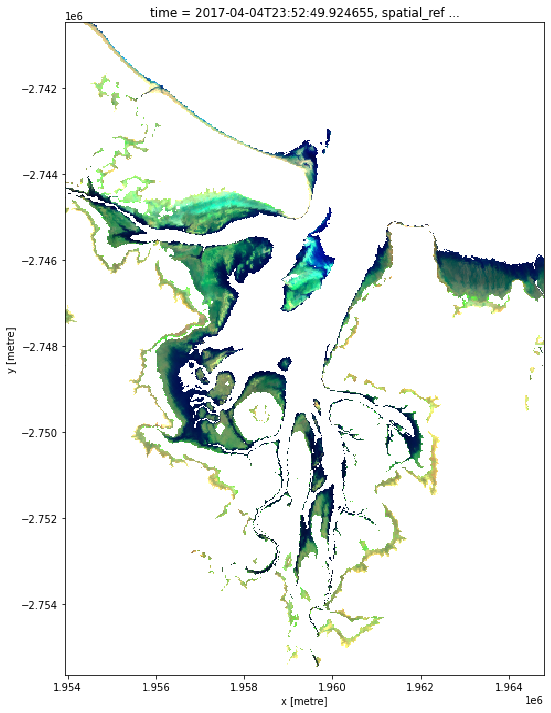

In [7]:
rgb(
    intertidal,    
#     bands=['nbart_red', 'nbart_green', 'nbart_blue'], ## RGB
    bands=['nbart_swir_1', 'nbart_nir', 'nbart_green'], ## False colour
    index=3,
    index_dim='time',
    robust=True,
    percentile_stretch=None,
    col_wrap=4,
    size=12
   )

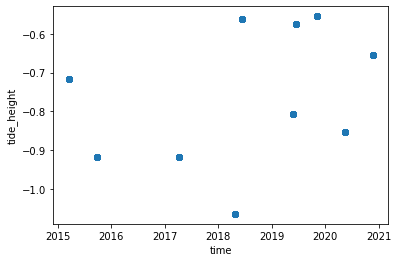

In [8]:
## Plot distribution of observations
intertidal.plot.scatter('time', 'tide_height')

## TODO: plot ebb and flow as separate series on the plot. Something like this:
# testebb = intertidal.where(intertidal.ebb_flow == 'ebb')
# testflow = intertidal.where(intertidal.ebb_flow == 'flow')

In [17]:
import numpy as np

In [21]:
print(intertidal['time'][0].values)

2001-06-01T23:59:59.500000000


In [23]:
print(np.array(intertidal['time'][0].values, 'y'))

TypeError: data type "y" not understood

### Next steps:
- filter out water pixels
- intersect with NESP temporal seagrass polygons
- calculate NDVI for known seagrass extents
- collate temporal stats
- plot statistical summaries 
    - do they highlight known areas of seagrass? 
    - Can any extra signals be determined such as seasonality or habitat migration?
    - are there temporal signals in non field-samples locations that match our seagrass?
- look for green algae with its separate NDVI response (nir?)

In [55]:
## Filter out water

##  Add a non-water pixel mask variable
intertidal['mask'] = (intertidal.NDWI <= 0)

##  Generate the NDWI_water class
intertidal['ndwi_water'] = ((intertidal.NDWI) > 0)

##  Generate NDVI classes

##  NDVI less than 0.1
intertidal['unveg'] = (intertidal.NDVI
                            .where((intertidal.NDVI < 0.1))#.astype(int))
                            )

##  NDVI 0.1 to 0.33
intertidal['ndvi_low'] = (intertidal.NDVI
                               .where((intertidal.NDVI >= 0.1) & #.astype(int) & 
                                      (intertidal.NDVI < 0.333))#.astype(int))
                               )

##  NDVI 0.33 to 0.66
intertidal['ndvi_mid'] = (intertidal.NDVI
                               .where((intertidal.NDVI >= 0.333) & #.astype(int) & 
                                      (intertidal.NDVI < 0.666))#.astype(int))
                               )

### NDVI 0.66 to 1
intertidal['ndvi_high'] = (intertidal.NDVI
                                .where((intertidal.NDVI >= 0.666) & #.astype(int) & 
                                       (intertidal.NDVI <= 1))#.astype(int))
                                )

##  Mask the NDVI classes to show non-water pixels only
intertidal['unveg'] = intertidal['unveg'].where(intertidal['mask'])
intertidal['ndvi_low'] = intertidal['ndvi_low'].where(intertidal['mask'])
intertidal['ndvi_mid'] = intertidal['ndvi_mid'].where(intertidal['mask'])
intertidal['ndvi_high'] = intertidal['ndvi_high'].where(intertidal['mask'])

##  Generate a bool denoting presence/absence of values
intertidal['unveg'] = intertidal['unveg'] > 0
intertidal['ndvi_low'] = intertidal['ndvi_low'] > 0
intertidal['ndvi_mid'] = intertidal['ndvi_mid'] > 0
intertidal['ndvi_high'] = intertidal['ndvi_high'] > 0


#                 for x in pg:
#                     if x == results2[str(k)][str(kk)].attrs['pgid']:
#                          ##  Populate pixel count lists per class per timestep
#                         for t in range (0, len(results2[str(k)][str(kk)].time)):
#                             ls_pixels.append(np.count_nonzero(~np.isnan(results2[str(k)][str(kk)].where(results2[k][kk][ITEM_mask]).isel(time=t).nbart_red)))
#                             ls_ndwi.append(np.count_nonzero(results2[str(k)][str(kk)].isel(time=t).ndwi_water))
#                             ls_unveg.append(np.count_nonzero(~np.isnan(results2[str(k)][str(kk)].isel(time=t).unveg)))
#                             ls_ndvilow.append(np.count_nonzero(~np.isnan(results2[str(k)][str(kk)].isel(time=t).ndvi_low)))
#                             ls_ndvimid.append(np.count_nonzero(~np.isnan(results2[str(k)][str(kk)].isel(time=t).ndvi_mid)))
#                             ls_ndvihigh.append(np.count_nonzero(~np.isnan(results2[str(k)][str(kk)].isel(time=t).ndvi_high)))
#                             ls_pxsum.append(np.count_nonzero(~np.isnan(results2[str(k)][str(kk)].where(results2[k][kk][ITEM_mask]).isel(time=t).nbart_red)))
#                             ls_tide.append(results2[str(k)][str(kk)].isel(time=t).tide_height.median().values)

#                         ls_index.append(results2[str(k)][str(kk)].time.values)
#     ls_index = np.concatenate(ls_index).tolist()
# #                                 index = results2[str(k)][str(kk)].time.values

# #         if classes == True:

# #              ##  Populate pixel count lists per class per timestep
# #             for t in range (0, len(results2.time)):
# #                 ls_pixels.append(np.count_nonzero(~np.isnan(results2.isel(time=t).nbart_red)))
# # #                 ls_mndwi.append(np.count_nonzero((results2.isel(time=t).mndwi_water)))
# #                 ls_mndwi.append(np.count_nonzero(~np.isnan(mWIT1.isel(time=t).mndwi_water.where(mWIT1.isel(time=t).mndwi_water == True))))
# #                 ls_unveg.append(np.count_nonzero(~np.isnan(results2.isel(time=t).unveg)))
# #                 ls_ndvilow.append(np.count_nonzero(~np.isnan(results2.isel(time=t).ndvi_low)))
# #                 ls_ndvimid.append(np.count_nonzero(~np.isnan(results2.isel(time=t).ndvi_mid)))
# #                 ls_ndvihigh.append(np.count_nonzero(~np.isnan(results2.isel(time=t).ndvi_high)))
# #                 ls_pxsum.append(np.count_nonzero(~np.isnan(results2.isel(time=t).nbart_red)))
# #                 ls_tide.append(results2.isel(time=t).tide_height.median().values)

# #                 index = results2.time.values


#     ## Return index values to datetime64
#     for x in range(0, len(ls_index)):
#         ls_index[x] = np.datetime64(int(ls_index[x]), 'ns')

#     ##  Generate a dataframe summarising class pixel counts per timestep
#     classes_df = pd.DataFrame(
#                 {"pixels": ls_pixels,
#                 "water": ls_ndwi,
#                 "unveg": ls_unveg,
#                 "ndvi_low": ls_ndvilow,
#                 "ndvi_mid": ls_ndvimid,
#                 "ndvi_high": ls_ndvihigh,
#                 "px_sum": ls_pxsum,
#                 "tide_height": ls_tide},
#                 index = ls_index
#                 )

#     ## Aggregate the datasets to account for identical imagery dates spanning different polygons
#     ## All pixel values are summed. Tide_height values are averaged
#     ## Separate tide_height dataset and convert to dataframe
#     classes_df_th = classes_df.tide_height
#     classes_df_th = pd.DataFrame(classes_df_th)

#     ## Drop tide_height from main df then group rows with duplicate indices and then sum them up
#     classes_df = classes_df.drop(['tide_height'], axis=1)
#     classes_df = classes_df.groupby(classes_df.index).sum()

#     ## Take tide-height values and convert from array to int
#     intlist=[]
#     for x in range (0,len(classes_df_th.tide_height.values.tolist())):
#         intlist.append(classes_df_th.tide_height.values.tolist()[x].tolist())

#     ## Add integer list to tide_height dataframe and drop array list
#     classes_df_th['th_int'] = intlist
#     classes_df_th = classes_df_th.drop('tide_height', axis=1)

#     ## Group by index dates as per classes_df and calculate mean tide_height value
#     classes_df_th = classes_df_th.groupby(classes_df_th.index).mean()

#     ## Merge the pixel and tide_height datasets back together
#     classes_df = classes_df.merge(classes_df_th, left_on = classes_df.index, right_on = classes_df_th.index)

#     ## Rename tide_height column to something sensible
#     classes_df = classes_df.rename(columns={'th_int':'tide_height'})

#     ## Reset the index to observation dates
#     classes_df.set_index('key_0', inplace=True)

#     ##  Normalise pixel counts per class per timestep
#     classes_df['pc_water'] = classes_df['water']/classes_df['pixels']*100
#     classes_df['pc_unveg'] = classes_df['unveg']/classes_df['pixels']*100
#     classes_df['pc_ndvi_low'] = classes_df['ndvi_low']/classes_df['pixels']*100
#     classes_df['pc_ndvi_mid'] = classes_df['ndvi_mid']/classes_df['pixels']*100
#     classes_df['pc_ndvi_high'] = classes_df['ndvi_high']/classes_df['pixels']*100
#     classes_df['pc_total'] = (classes_df['pc_water']+
#                               classes_df['pc_unveg']+
#                               classes_df['pc_ndvi_low']+
#                               classes_df['pc_ndvi_mid']+
#                               classes_df['pc_ndvi_high'])
#     classes_df['pc_exposedpx'] = (classes_df['unveg']+
#                                   classes_df['ndvi_low']+
#                                   classes_df['ndvi_mid']+
#                                   classes_df['ndvi_high'])/classes_df['px_sum']*100


In [56]:
intertidal

<xarray.Dataset>
Dimensions:       (time: 11, x: 434, y: 607)
Coordinates:
  * time          (time) datetime64[ns] 2001-06-01T23:59:59.500000 ... 2020-1...
  * y             (y) float64 -2.74e+06 -2.741e+06 ... -2.756e+06 -2.756e+06
  * x             (x) float64 1.954e+06 1.954e+06 ... 1.965e+06 1.965e+06
    spatial_ref   int32 3577
Data variables:
    nbart_red     (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_green   (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_blue    (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_nir     (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_swir_1  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    tide_height   (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    NDVI          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    MNDWI         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    NDAVI         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    WAVI          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    EVI           (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    SAVI          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    NDWI          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    LAI           (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    ebb_flow      (time, y, x) object nan nan nan nan nan ... nan nan nan nan
    relative      (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    mask          (time, y, x) bool False False False ... False False False
    ndwi_water    (time, y, x) bool False False False ... False False False
    unveg         (time, y, x) bool False False False ... False False False
    ndvi_low      (time, y, x) bool False False False ... False False False
    ndvi_mid      (time, y, x) bool False False False ... False False False
    ndvi_high     (time, y, x) bool False False False ... False False False

In [62]:
# test = intertidal['ndvi_high'].mean('time')
# test.plot()
intertidal


<xarray.Dataset>
Dimensions:       (time: 11, x: 434, y: 607)
Coordinates:
  * time          (time) datetime64[ns] 2001-06-01T23:59:59.500000 ... 2020-1...
  * y             (y) float64 -2.74e+06 -2.741e+06 ... -2.756e+06 -2.756e+06
  * x             (x) float64 1.954e+06 1.954e+06 ... 1.965e+06 1.965e+06
    spatial_ref   int32 3577
Data variables:
    nbart_red     (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_green   (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_blue    (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_nir     (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    nbart_swir_1  (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    tide_height   (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    NDVI          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    MNDWI         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    NDAVI         (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    WAVI          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    EVI           (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    SAVI          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    NDWI          (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    LAI           (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    ebb_flow      (time, y, x) object nan nan nan nan nan ... nan nan nan nan
    relative      (time, y, x) float64 nan nan nan nan nan ... nan nan nan nan
    mask          (time, y, x) bool False False False ... False False False
    ndwi_water    (time, y, x) bool False False False ... False False False
    unveg         (time, y, x) bool False False False ... False False False
    ndvi_low      (time, y, x) bool False False False ... False False False
    ndvi_mid      (time, y, x) bool False False False ... False False False
    ndvi_high     (time, y, x) bool False False False ... False False False

In [58]:
# test.plot()
test = xr.Dataset()
# test = intertidal['NDVI'].to_dataset
test

<xarray.Dataset>
Dimensions:  ()
Data variables:
    *empty*

In [59]:
## Needs to be

test['ndwi_water'] = intertidal['ndwi_water'].mean('time')
test['unveg'] = intertidal['unveg'].mean('time')
test['ndvi_low'] = intertidal['ndvi_low'].mean('time')
test['ndvi_mid'] = intertidal['ndvi_mid'].mean('time')
test['ndvi_high'] = intertidal['ndvi_high'].mean('time')

In [60]:
test['sum'] = test['unveg']+test['ndvi_low']+test['ndvi_mid']+test['ndvi_high']+test['ndwi_water']
test

<xarray.Dataset>
Dimensions:      (x: 434, y: 607)
Coordinates:
  * y            (y) float64 -2.74e+06 -2.741e+06 ... -2.756e+06 -2.756e+06
  * x            (x) float64 1.954e+06 1.954e+06 ... 1.965e+06 1.965e+06
    spatial_ref  int32 3577
Data variables:
    ndwi_water   (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    unveg        (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ndvi_low     (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ndvi_mid     (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    ndvi_high    (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    sum          (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [61]:
# test['ndwi_water'].plot()
test['sum'].max()

<xarray.DataArray 'sum' ()>
array(0.90909091)
Coordinates:
    spatial_ref  int32 3577